In [1]:
#import sys
#!{sys.executable} -m pip install countryinfo

In [2]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from countryinfo import CountryInfo
from fbprophet import Prophet

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.style.use('fivethirtyeight')

# Load data
data = pd.read_csv('covid_data.csv')

In [3]:
data.shape

(39347, 8)

In [4]:
data.dtypes

SNo                  int64
ObservationDate     object
Province/State      object
Country/Region      object
Last Update         object
Confirmed          float64
Deaths             float64
Recovered          float64
dtype: object

In [5]:
# Convert dates
data['ObservationDate'] = pd.to_datetime(data['ObservationDate'])

print('The dataset begins on {} and ends on {}..'.format(min(data['ObservationDate']), max(data['ObservationDate']))) 

The dataset begins on 2020-01-22 00:00:00 and ends on 2020-06-10 00:00:00..


In [20]:
data.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,2020-01-22,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,2020-01-22,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,2020-01-22,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,2020-01-22,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,2020-01-22,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


In [8]:
# Calculate global effects
global_d = data.groupby('ObservationDate').agg({'Deaths': 'sum',
                                                'Confirmed': 'sum',
                                                'Recovered': 'sum'})

In [9]:
global_d.tail()

,Deaths,Confirmed,Recovered
ObservationDate,,,
2020-06-06,399999.0,6896917.0,3085833.0
2020-06-07,402744.0,7010582.0,3140920.0
2020-06-08,406543.0,7119002.0,3293408.0
2020-06-09,411436.0,7242235.0,3375668.0
2020-06-10,416201.0,7360239.0,3454807.0


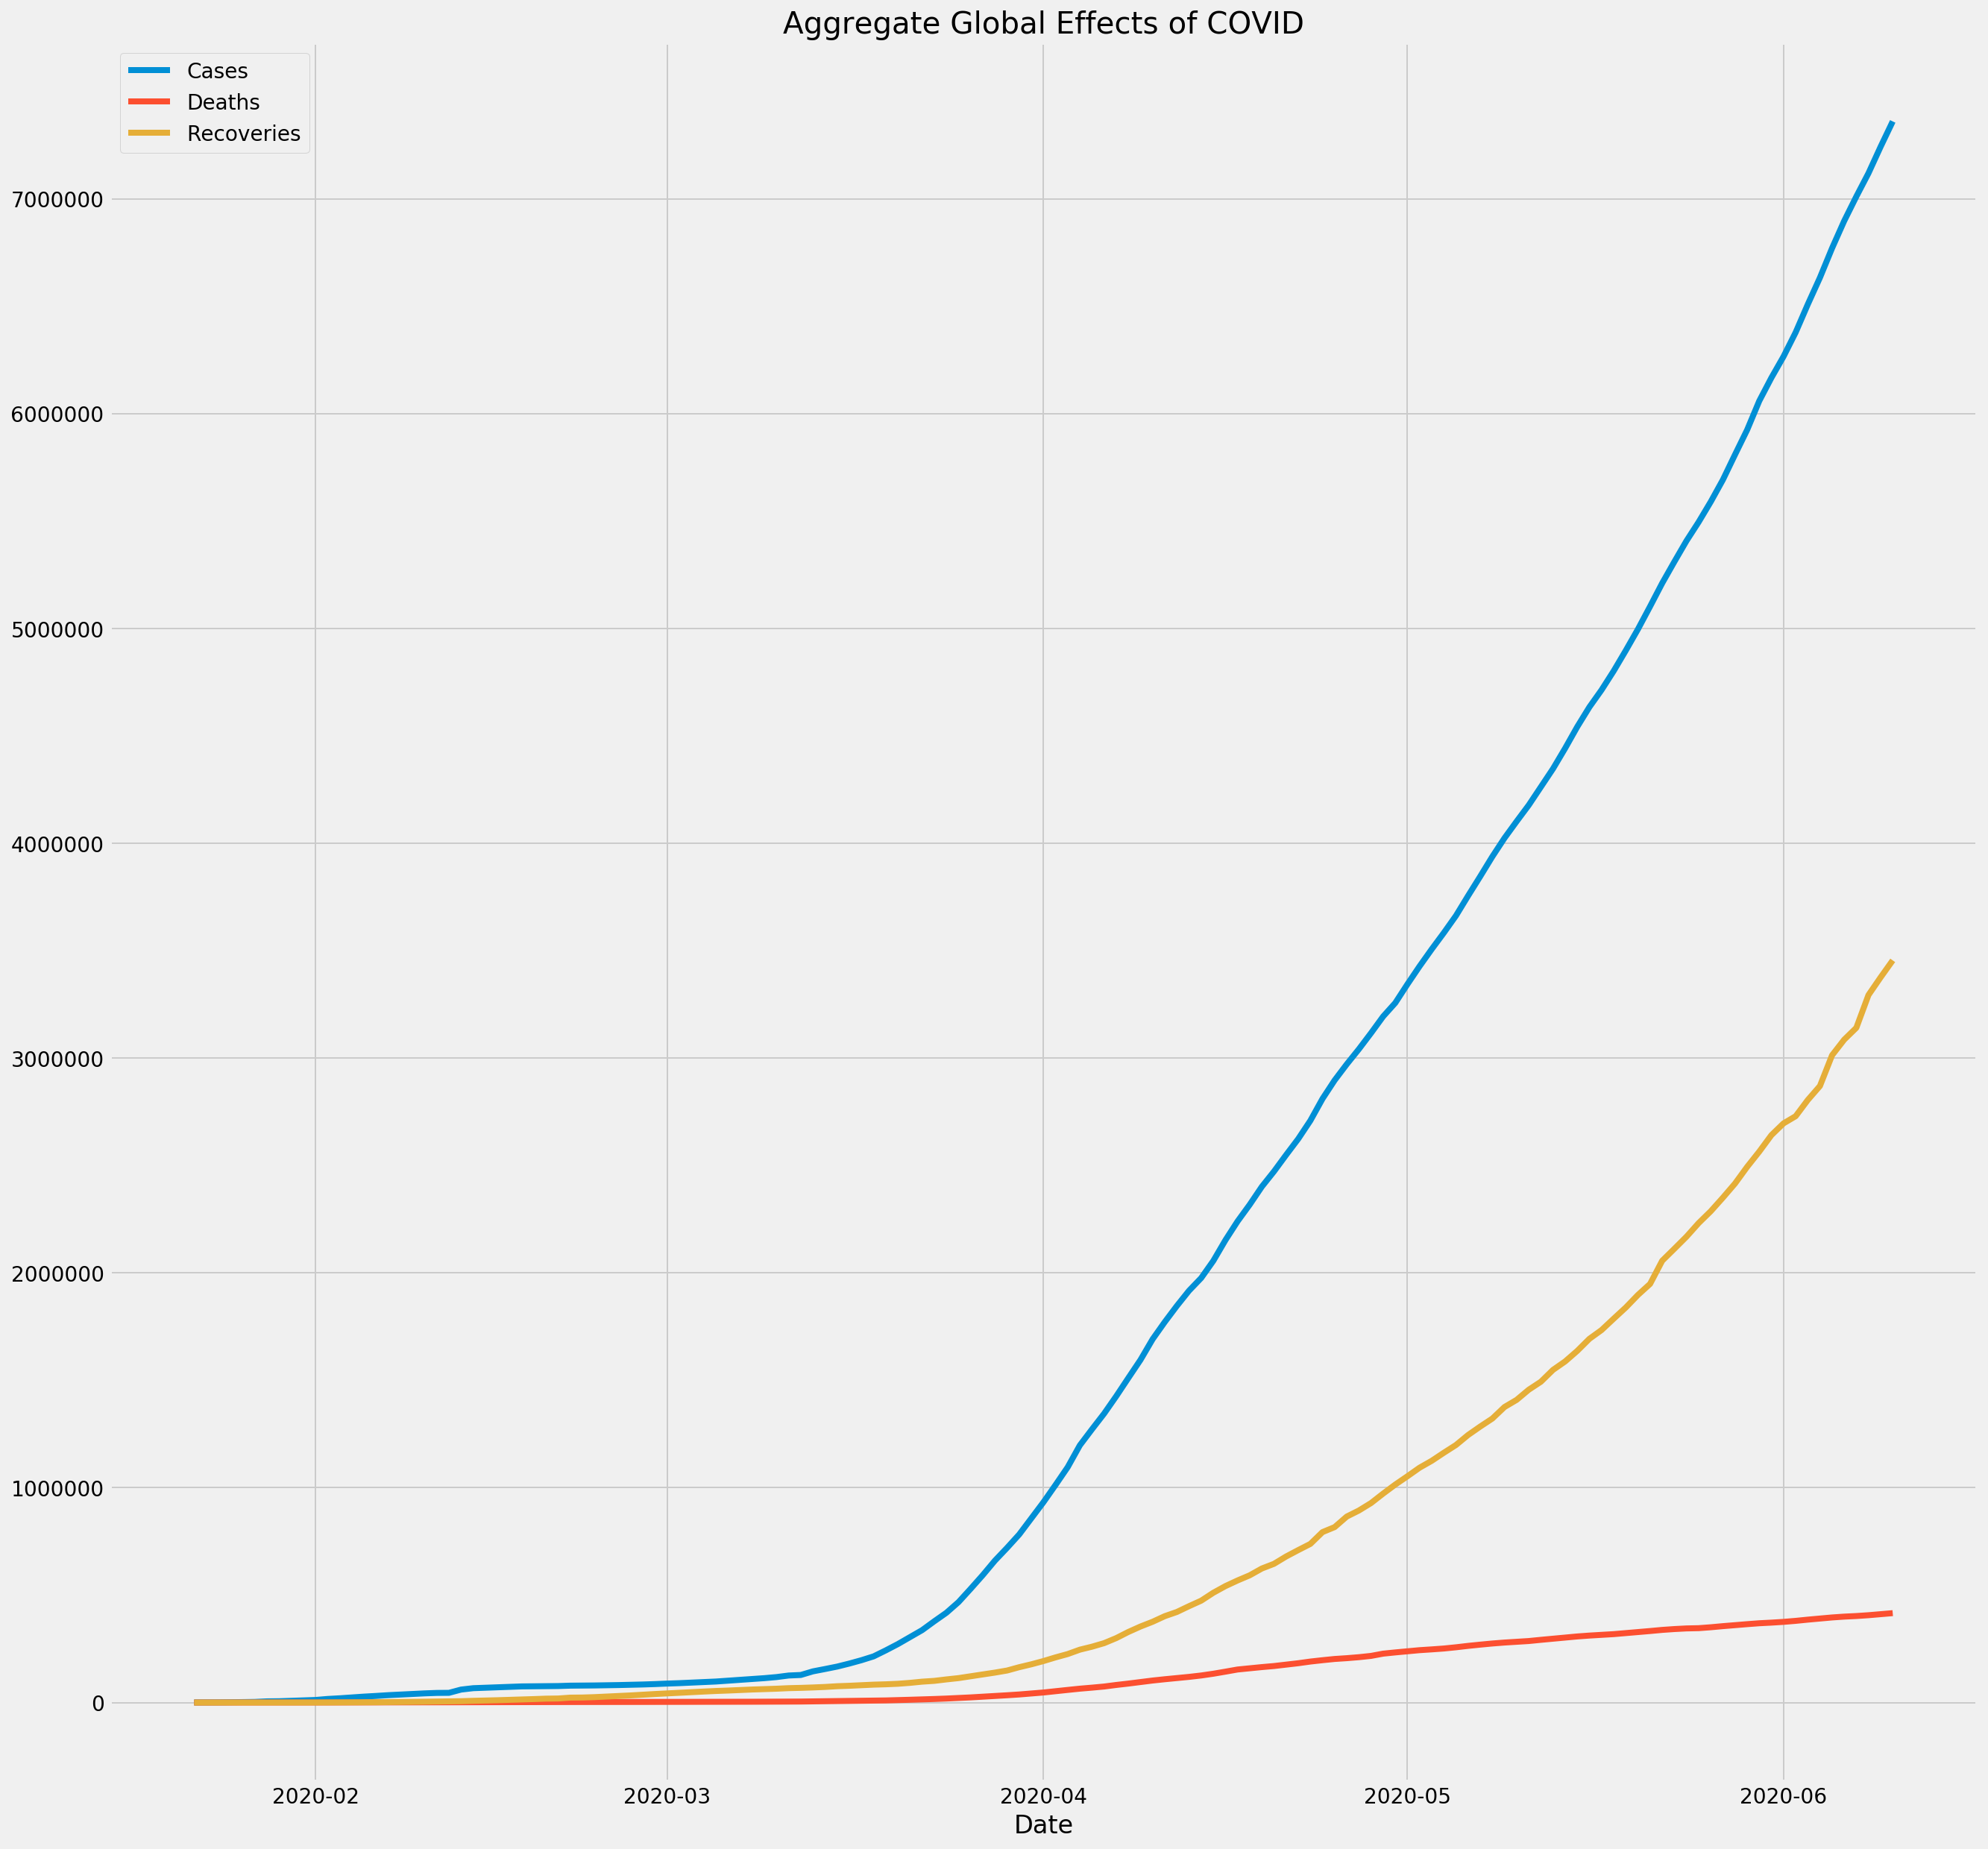

In [10]:
fig, ax = plt.subplots(figsize = [20, 20])
ax.plot(global_d['Confirmed'], label = 'Cases')
ax.plot(global_d['Deaths'], label = 'Deaths')
ax.plot(global_d['Recovered'], label = 'Recoveries')
ax.set_title('Aggregate Global Effects of COVID')
ax.set_xlabel('Date')
ax.legend()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


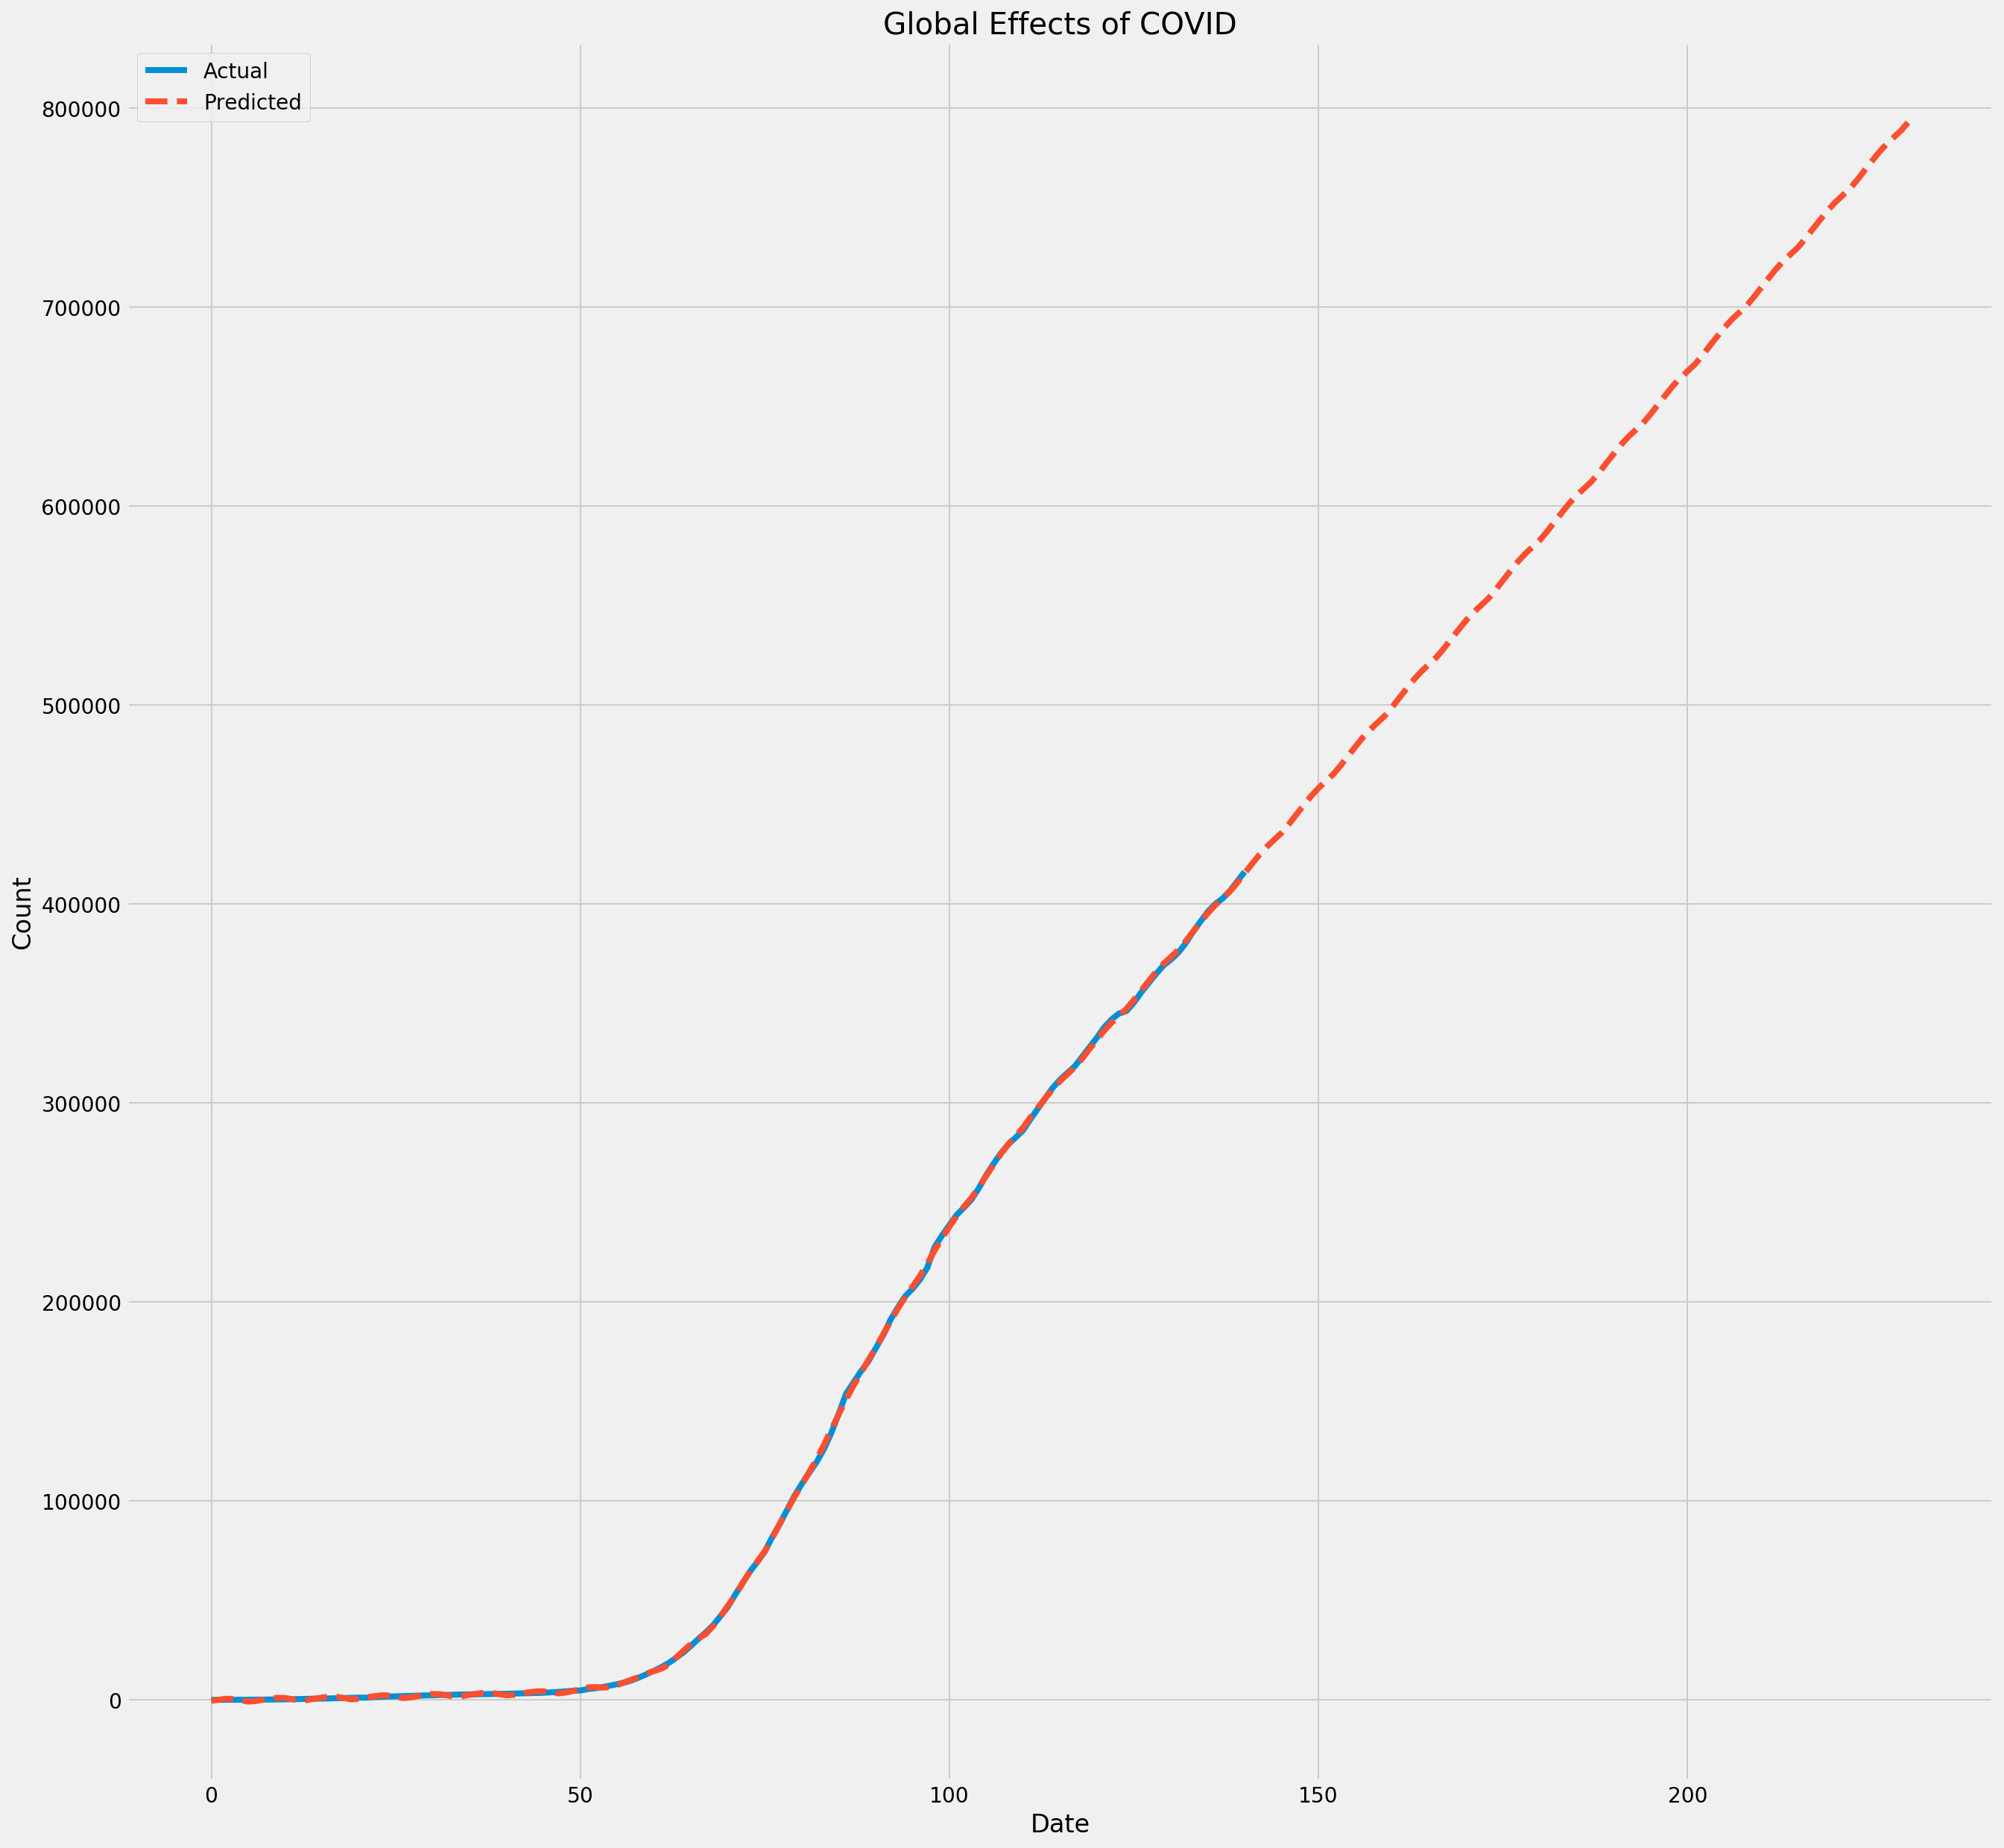

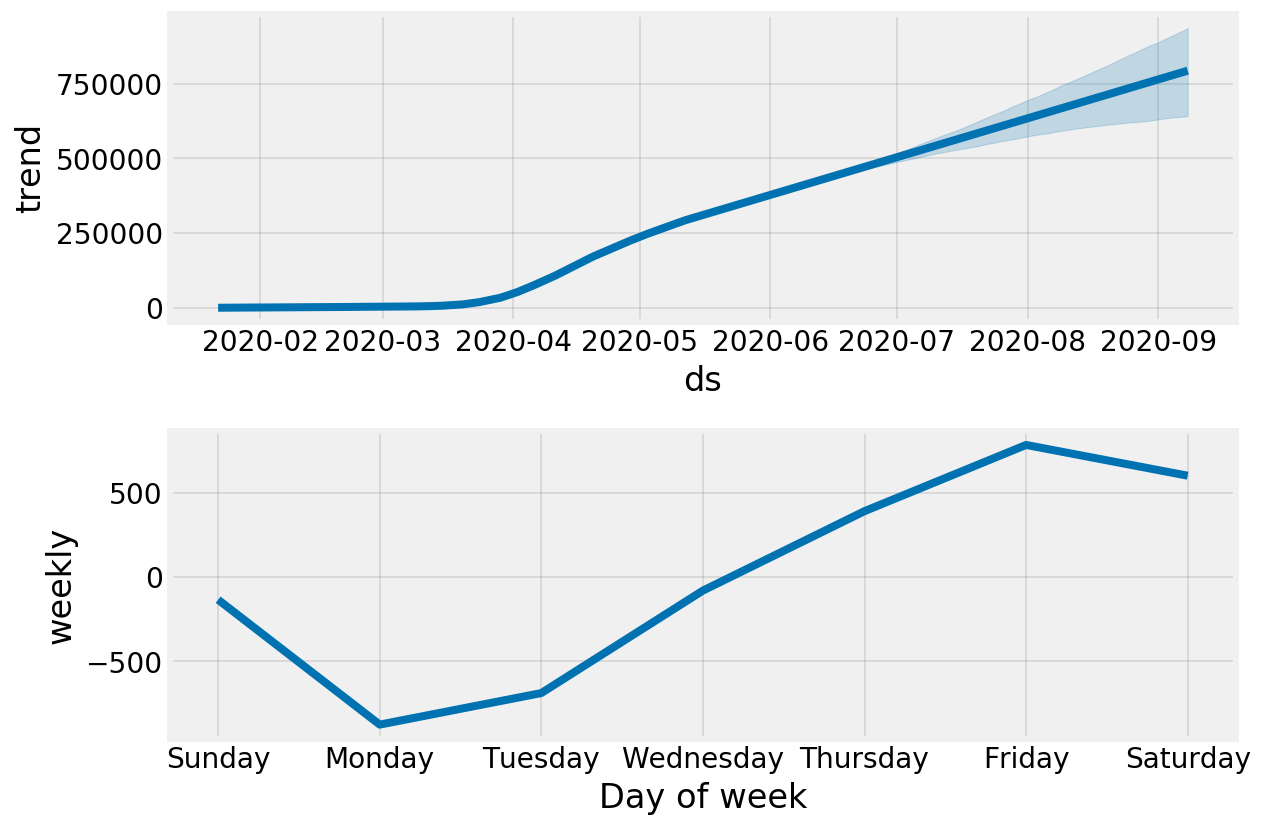

In [19]:
# Transform the data for mkodeling
fcst_data = global_d[['Deaths']].reset_index().rename({'ObservationDate': 'ds', 'Deaths': 'y'}, axis = 1)

# Initialize
m = Prophet()
m.fit(fcst_data)

# Predict
fut = m.make_future_dataframe(periods = 90)
preds = m.predict(fut)

# Visualize
fig, ax = plt.subplots(figsize = [20, 20])
ax.plot(fcst_data['y'], label = 'Actual')
ax.plot(preds['yhat'], label = 'Predicted', linestyle = '--')
ax.legend()
ax.set_title('Global Effects of COVID')
ax.set_xlabel('Date')
ax.set_ylabel('Count');

m.plot_components(preds);

In [71]:
# Initialize dict to store info
d = {}
s = {}
# Iterate groups in dataset
for nm, grp in data.groupby(['Country/Region']):
    
    # Aggregate
    deaths = grp.groupby('ObservationDate')['Deaths'].sum().cumsum().reset_index()
    cases = grp.groupby('ObservationDate')['Confirmed'].sum().cumsum().reset_index()
    recoveries = grp.groupby('ObservationDate')['Recovered'].sum().cumsum().reset_index()

    # Merge
    stats = cases.merge(deaths, on = 'ObservationDate').merge(recoveries, on = 'ObservationDate')
    
    # Adjust index for predictions
    stats.set_index('ObservationDate', inplace = True)
    
    # Update master
    d[nm] = stats
    
    # Get location info
    info = CountryInfo(nm)
    s[nm] = info

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


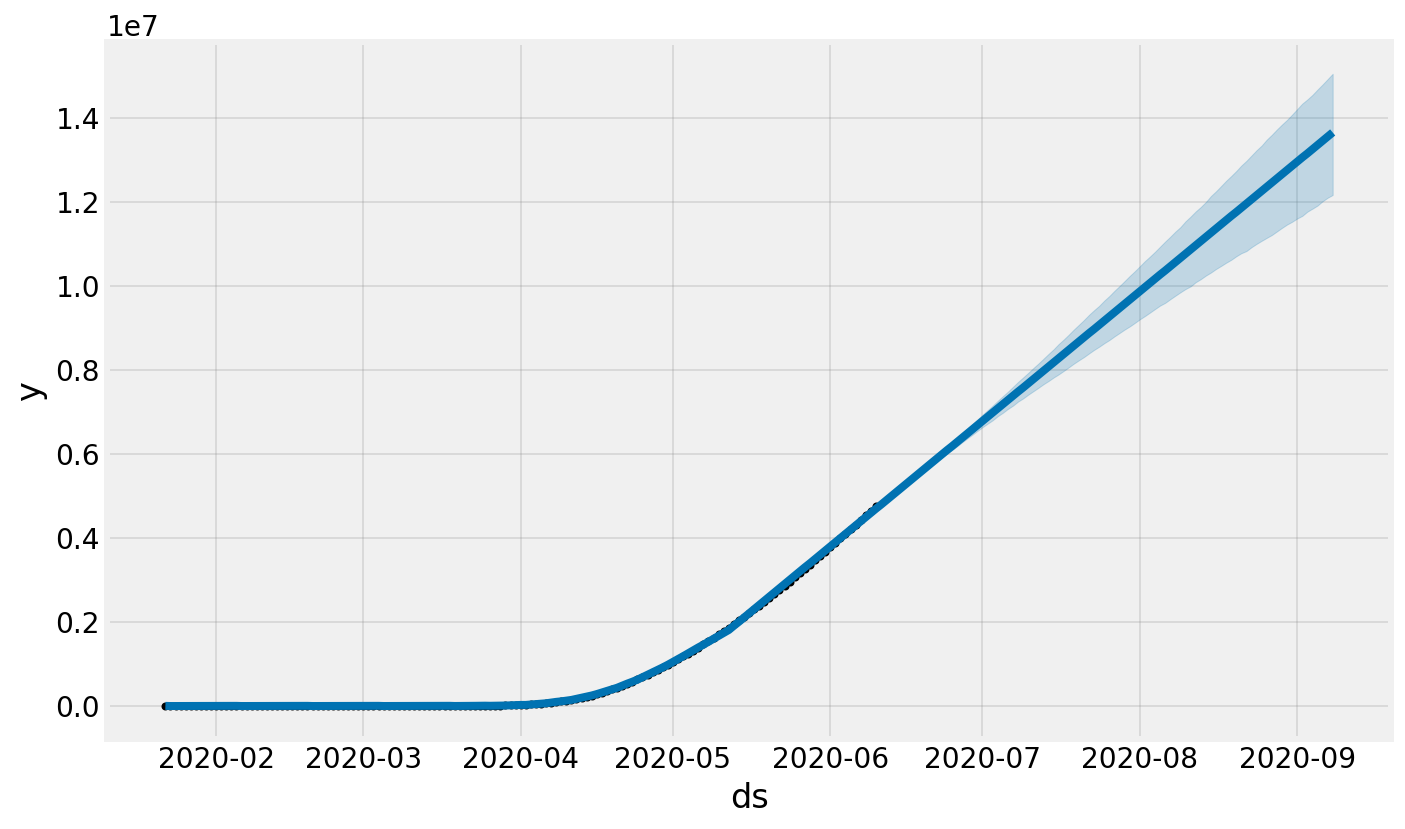

In [80]:
# Configure data for modeling
deaths = d['US']['Deaths'].reset_index().rename({'Deaths': 'y',
                                                 'ObservationDate': 'ds'}, axis = 1)

# Model
m = Prophet()
m.fit(deaths)

# Predict
fut = m.make_future_dataframe(periods = 90)
pred = m.predict(fut)

# Visualize
m.plot(pred);

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


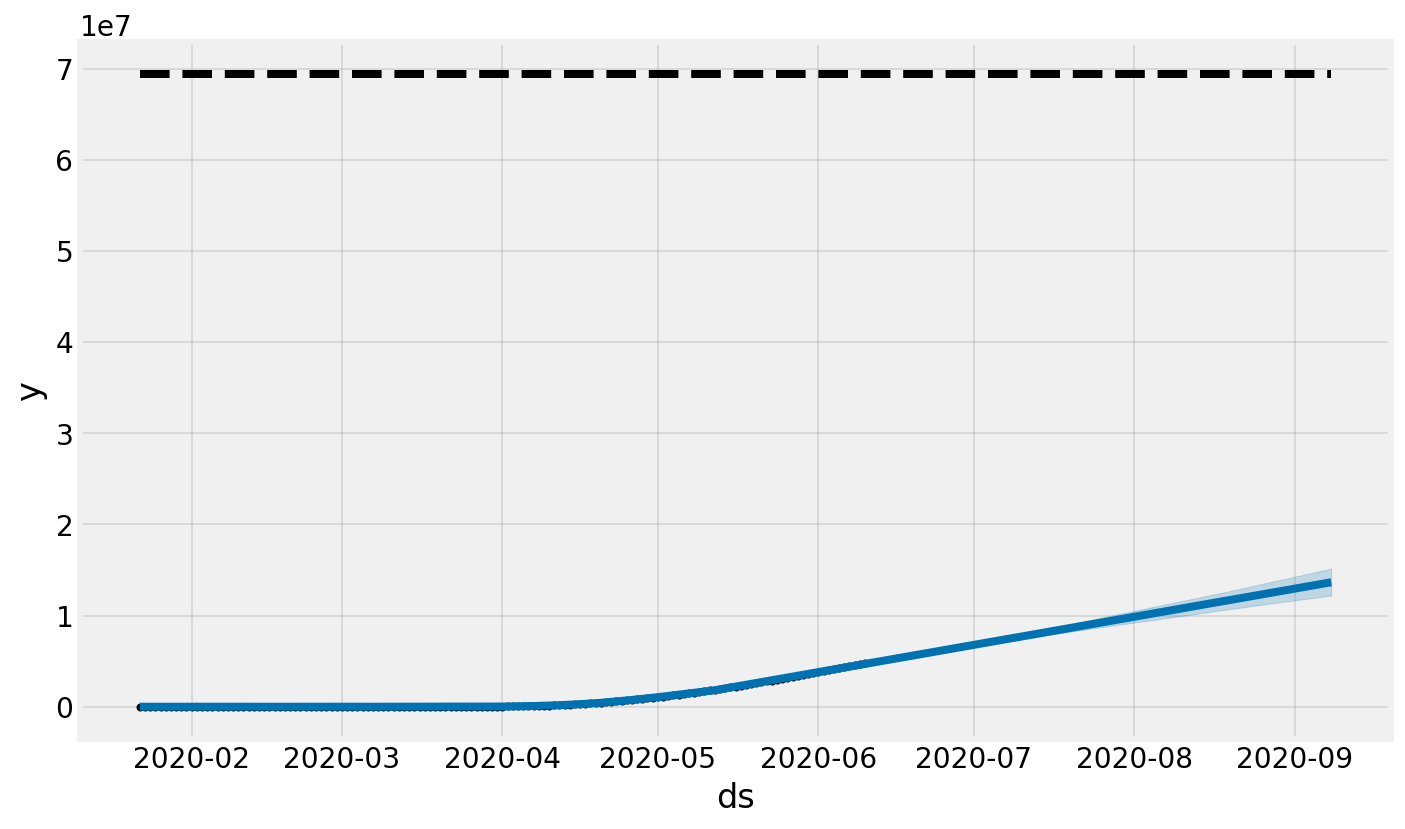

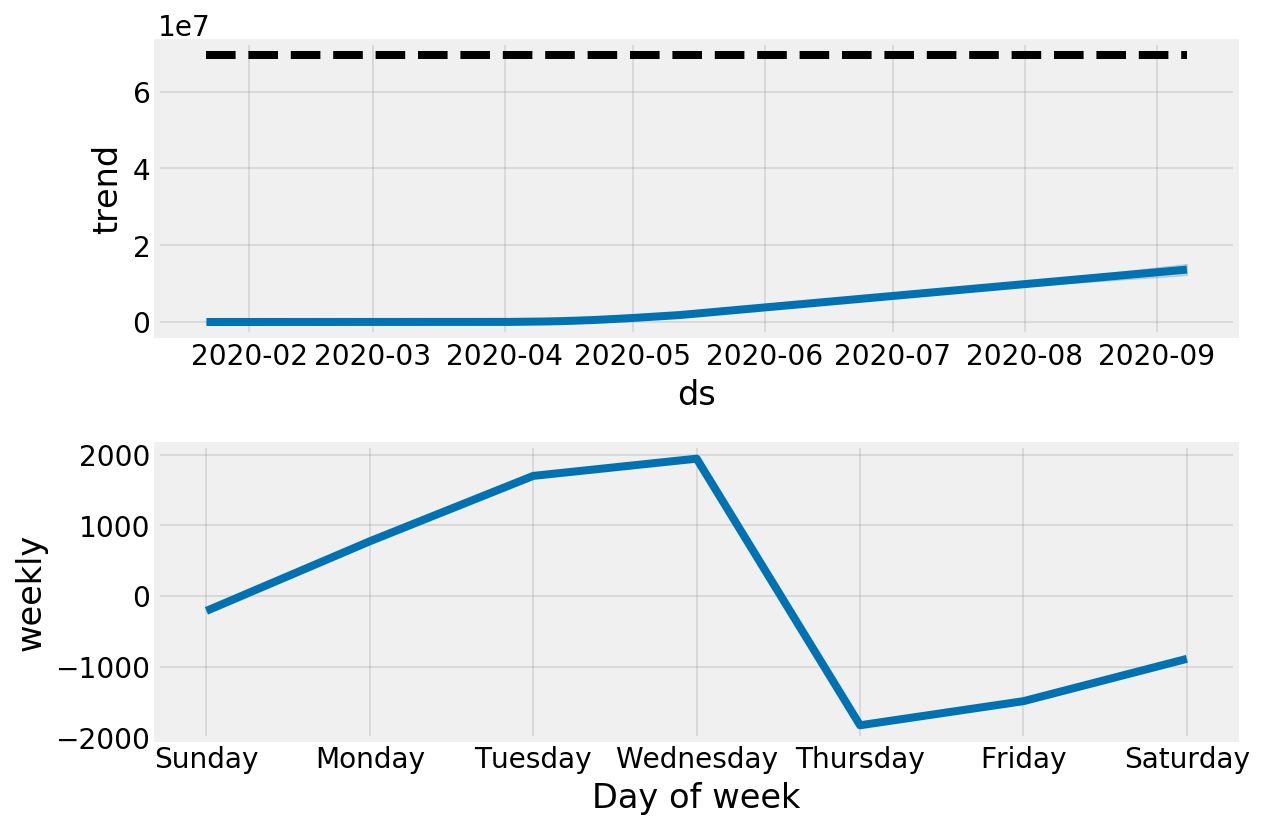

In [87]:
deaths['floor'] = 0
deaths['cap'] = max(d['US']['Confirmed']) - max(d['US']['Recovered'])
                           
# Model
m = Prophet()
m.fit(deaths)

fut = m.make_future_dataframe(periods = 90)
fut['floor'] = 0
fut['cap'] = max(d['US']['Confirmed']) - max(d['US']['Recovered'])

pred = m.predict(fut)

m.plot(pred);
m.plot_components(pred);